In [1]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from typing import Tuple

In [3]:
d_train = np.load(
    "/content/drive/MyDrive/Colab Notebooks/amath 582 lecture notes/reports /MNIST_training_set.npy",
    allow_pickle=True)
d_test = np.load(
    "/content/drive/MyDrive/Colab Notebooks/amath 582 lecture notes/reports /MNIST_test_set.npy",
    allow_pickle=True)

In [4]:
X_train = d_train.item().get('features')
Y_train = d_train.item().get('labels')

print(X_train.shape)
print(Y_train.shape)

X_test = d_test.item().get('features')
Y_test = d_test.item().get('labels')

print(X_test.shape)
print(Y_test.shape)

(2000, 256)
(2000,)
(500, 256)
(500,)


[1. 1. 1. 6. 0. 4. 9. 9. 3. 7. 1. 8. 3. 8. 7. 4. 3. 4. 0. 2. 5. 6. 2. 6.
 0. 0. 9. 0. 8. 1. 2. 7. 9. 7. 4. 5. 2. 4. 9. 3. 3. 1. 8. 8. 6. 4. 6. 3.
 0. 3. 1. 1. 7. 8. 9. 4. 0. 7. 7. 0. 0. 7. 2. 6.]


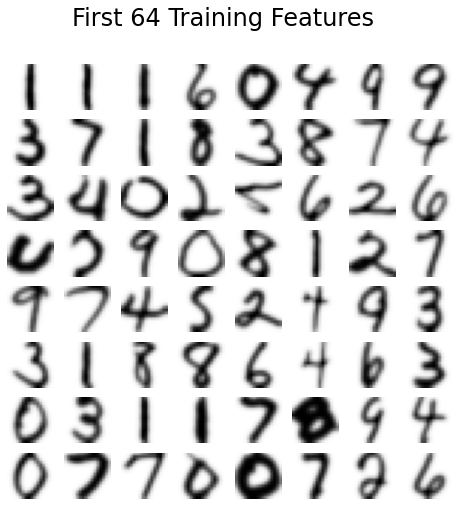

In [5]:
# Plot some of the training and test sets


def plot_digits(XX, N, title):
    """Small helper function to plot N**2 digits."""
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    for i in range(N):
        for j in range(N):
            ax[i, j].imshow(XX[(N) * i + j, :].reshape((16, 16)), cmap="Greys")
            ax[i, j].axis("off")
    fig.suptitle(title, fontsize=24)


plot_digits(X_train, 8, "First 64 Training Features")

print(Y_train[0:8**2])

# Task 1
> Use PCA to investigate the dimensionality of $ùëã_{train}$ and plot the first 16 PCA modes as 16 √ó16 images

Text(0, 0.5, '$\\log(\\sigma_j)$')

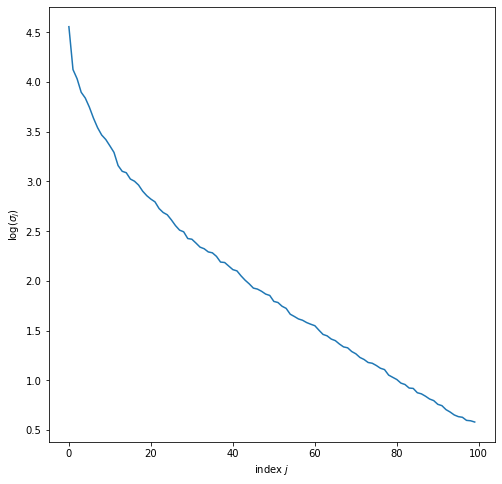

In [6]:
# Analyzing the first 100 singular values
pca = PCA()
pca.fit(X_train)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.plot(np.log(pca.singular_values_[0:100]))
ax.set_xlabel('index $j$')
ax.set_ylabel('$\log(\sigma_j)$')

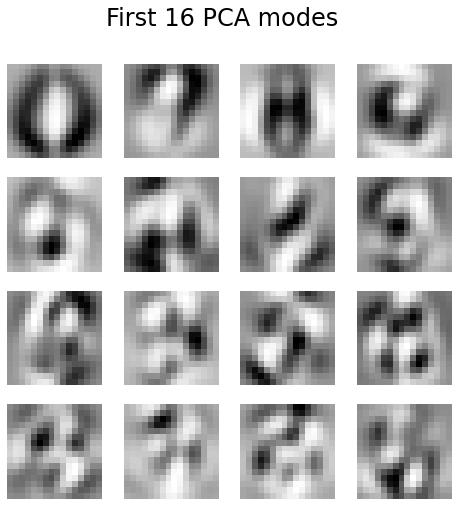

In [7]:
plot_digits(pca.components_, 4, 'First 16 PCA modes')

# Task 2
> How many PCA modes do you need to keep in order to approximate $ùëã_{train}$ up to 60%,80% and 90% in the Frobenius norm? Do you need the entire 16 √ó16 image for each data point?

In [8]:
# define function to get the num of modes needed for keeping specific percent of Frobenius norm
F_norm = np.sqrt(sum(pca.singular_values_**2))


def find_num_of_modes(percent: float) -> int:
    for _ in range(100):
        approx_F_norm = np.sqrt(sum(pca.singular_values_[:_]**2))
        if approx_F_norm >= F_norm * percent:
            return _


percents = [0.6, 0.8, 0.9]
print('number of modes needed respectively:',
      *list(map(find_num_of_modes, percents)))

number of modes needed respectively: 3 7 14


From this, we can see that not the entire 16$\times$16 image is needed for each data point. Only the first few or several modes are needed for approximation.

# Task 3
> Train a classifier to distinguish the digits 1 and 8 via the following steps:
* First, you need to write a function that extracts the features and labels of the digits 1 and 8 from
the training data set. Let us call these ùëã(1,8) and ùëå(1,8).
* Then project ùëã(1,8) on the first 16 PCA modes of $ùëã_{train}$ computed in step 1, this should give you a matrix $ùê¥_{train}$ which has 16 columns corresponding to the PCA coefficients of each feature and 455 rows corresponding to the total number of 1‚Äôs and 8‚Äôs in the training set. 
* Assign label ‚àí1 to the images of the digit 1 and label +1 to the images of the digit 8. This should result in a vector $ùëè_{train}$ ‚àà{‚àí1,+1}$^{455}$.
* Use Ridge regression or least squares to train a predictor for the vector $b_{train}$ by linearly combining the columns of $A_{train}$.
* Report the training mean squared error (MSE) of your classifier
$$MSE_{train}(1,8) = \frac{1}{\text{length of }ùëè_{train}}√ó‚Äñùê¥_{train} \hat{ùõΩ} ‚àíùëè_{train}‚Äñ_2^2$$
* Report the testing MSE of your classifier $$MSE_{test}(1,8) = \frac{1}{\text{length of }ùëè_{test}}√ó‚Äñùê¥_{test} \hat{ùõΩ} ‚àíùëè_{test}‚Äñ_2^2$$ where you need to construct analogously the matrix $ùê¥_{test}$ and $ùëè_{test}$ corresponding to the digits 1 and 8 from the test data set.


In [9]:
# perform 16 modes PCA
pca_16 = PCA(n_components=16)

# define fuction to extract relevant features with labels n1 ,n2
# return A for 16 modes PCA transforming A_train
# return b for b_train of labeling -1 to 1 and 1 to 8


def extract_relavent_features(n1: int, n2: int, X: np.array,
                              Y: np.array) -> Tuple[np.array, list]:
    N = len(X)
    index = [i for i in range(N) if Y[i] == n1 or Y[i] == n2]
    A = pca_16.fit_transform(X)[index]
    b = list(map(lambda x: -1 if Y[index][x] == n1 else 1, range(len(index))))
    return A, b


# get the A_train, b_train as well as the A_test, b_test
A_train, b_train = extract_relavent_features(1, 8, X_train, Y_train)
A_test, b_test = extract_relavent_features(1, 8, X_test, Y_test)

In [10]:
# two Ridge regression for different alphas, 1 and 0.02

reg1 = Ridge(alpha=1)
reg1.fit(A_train, b_train)

reg2 = Ridge(alpha=0.02)
reg2.fit(A_train, b_train)

Ridge(alpha=0.02)

In [11]:
# calculating MSE for train and test set for alpha = 1
b = np.insert(reg1.coef_, 0, reg1.intercept_)

MSE_train = 1/len(b_train) * \
    np.linalg.norm((np.dot(A_train, b[1:])+b[0]-b_train), 2)**2
MSE_test = 1/len(b_test) * \
    np.linalg.norm((np.dot(A_test, b[1:])+b[0]-b_test), 2)**2

print(
    f'For alpha = 1, the MSE for train set is {MSE_train} and {MSE_test} for test set'
)

For alpha = 1, the MSE for train set is 0.07461342435427917 and 0.13818362089459907 for test set


In [12]:
# calculating MSE for train and test set for alpha = 0.02
b = np.insert(reg2.coef_, 0, reg2.intercept_)

MSE_train = 1/len(b_train) * \
    np.linalg.norm((np.dot(A_train, b[1:])+b[0]-b_train), 2)**2
MSE_test = 1/len(b_test) * \
    np.linalg.norm((np.dot(A_test, b[1:])+b[0]-b_test), 2)**2

print(
    f'For alpha = 0.02, the MSE for train set is {MSE_train} and {MSE_test} for test set'
)

For alpha = 0.02, the MSE for train set is 0.07459894314853126 and 0.13507635517360442 for test set


We see that two different alphas give results that are very close. The smaller alpha =0.02 gives a slightly smaller MSE. So for the next part, we use alpha =0.02.

# Task 4
> Use your code from step 3 to train classifiers for the pairs of digits (3,8) and (2,7) and report the training and test MSE‚Äôs. Can you explain the performance variations?

In [13]:
# for number 3 and 8

A_train, b_train = extract_relavent_features(3, 8, X_train, Y_train)
A_test, b_test = extract_relavent_features(3, 8, X_test, Y_test)

reg = Ridge(alpha=0.02)
reg.fit(A_train, b_train)

# calculating MSE for train and test set for alpha = 0.02
b = np.insert(reg.coef_, 0, reg.intercept_)

MSE_train = 1/len(b_train) * \
    np.linalg.norm((np.dot(A_train, b[1:])+b[0]-b_train), 2)**2
MSE_test = 1/len(b_test) * \
    np.linalg.norm((np.dot(A_test, b[1:])+b[0]-b_test), 2)**2

print(
    f'For alpha = 0.02, the MSE for train set is {MSE_train} and {MSE_test} for test set'
)

For alpha = 0.02, the MSE for train set is 0.18040056927478518 and 0.5700102111884255 for test set


In [14]:
# for number 2 and 7

A_train, b_train = extract_relavent_features(2, 7, X_train, Y_train)
A_test, b_test = extract_relavent_features(2, 7, X_test, Y_test)

reg = Ridge(alpha=0.02)
reg.fit(A_train, b_train)

# calculating MSE for train and test set for alpha = 0.02
b = np.insert(reg.coef_, 0, reg.intercept_)

MSE_train = 1/len(b_train) * \
    np.linalg.norm((np.dot(A_train, b[1:])+b[0]-b_train), 2)**2
MSE_test = 1/len(b_test) * \
    np.linalg.norm((np.dot(A_test, b[1:])+b[0]-b_test), 2)**2

print(
    f'For alpha = 0.02, the MSE for train set is {MSE_train} and {MSE_test} for test set'
)

For alpha = 0.02, the MSE for train set is 0.09177852736527603 and 0.3742354809625476 for test set


We see that for the model's MSE is higher for telling 3 and 8 apart from the other. This makes sense because the number '3' and number '8' look more alike, both from human eyes and from machines. 